In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

import xarray as xr
import numpy as np
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [ ]:
#Based on CNN code provided in class and on PyTorch documentation / tutorial page (see report for citation)

class RadarCNNInter(nn.Module):
    def __init__(self):
        super(RadarCNNInter, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, 3)
        self.pool1 = nn.MaxPool3d(2, 2)
        self.conv2 = nn.Conv3d(16, 64, 2)
        self.pool2 = nn.MaxPool3d(3, 3)
        self.conv3 = nn.Conv2d(64, 256, 3)
        self.pool3 = nn.MaxPool2d(16, 16)
        self.linear1 = nn.Linear(256 * 16, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(torch.squeeze(x))))
        x = F.relu(self.linear1(torch.flatten(x)))
        x = F.sigmoid(self.linear2(x))
        return x


In [ ]:
#Another version of the model I was testing for a bit

class RadarCNNInter2(nn.Module):
    def __init__(self):
        super(RadarCNNInter2, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, 3, padding = 'same')
        self.pool1 = nn.MaxPool3d(2, 2)
        self.conv2 = nn.Conv3d(16, 64, (1, 3, 3))
        self.pool2 = nn.MaxPool3d((1, 3, 3))
        self.conv3 = nn.Conv3d(64, 256, 3)
        self.pool3 = nn.MaxPool3d((1, 4, 4))
        self.conv4 = nn.Conv3d(256, 1024, (1, 3, 3), padding = 'same')
        self.pool4 = nn.MaxPool3d((1, 4, 4))
        self.linear1 = nn.Linear(1024 * 4 * 4 * 3, 16)
        self.linear2 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = F.relu(self.linear1(torch.flatten(x)))
        x = F.sigmoid(self.linear2(x))
        return x


In [ ]:
#Create model object
model = RadarCNNInter()

In [ ]:
import torch.optim as optim

criterion = nn.BCELoss() #Use binary cross entropy loss
optimizer = optim.SGD(model.parameters(), lr=0.001) #Use stochastic gradient descent optimizer

In [6]:
# View a sample radar file
# xr.open_dataset(r"C:\Users\benja\Downloads\radar_file_11.nc").squeeze().reflectivity.fillna(0).sel(z = 1000).plot(cmap = 'NWSRef', vmin = 5, vmax = 75)

In [ ]:
#Get training data from local drive

inputdatalist = []
num_events = 0
num_null = 0
num_tstm_nonevent = 0
num_stratiform_nonevent = 0

#Iterate through 500 events
for i in range(500):
    try:
        #Load in reflectivity data, set NaNs to zero
        inputdata = xr.open_dataset(r"C:\Users\benja\Downloads\radar_file_" + str(i) + ".nc").squeeze().reflectivity.fillna(0).to_numpy()[0:10, :, :]
        inputdata = np.where(inputdata >= 0, inputdata, 0) #Set negative values to zero
        inputdata = np.expand_dims(inputdata, 0) #Get dimensions to work with PyTorch model
        inputdata = torch.tensor(inputdata)
        inputdatalist.append(inputdata) #Append tensor to inputdatalist
        num_events += 1

    except:
        print('No event file for index ' + str(i))
        continue

print('Number of events: ' + str(num_events))

#Repeat for random non-events
for i in range(500):
    try:
        inputdata2 = xr.open_dataset(r"C:\Users\benja\Downloads\null_radar_file_" + str(i) + ".nc").squeeze().reflectivity.fillna(0).to_numpy()[0:10, :, :]
        inputdata2 = np.where(inputdata2 >= 0, inputdata2, 0)
        inputdata2 = np.expand_dims(inputdata2, 0)
        inputdata2 = torch.tensor(inputdata2)
        inputdatalist.append(inputdata2)
        num_null += 1

    except:
        print('No null file for index ' + str(i))
        continue

print('Number of nulls: ' + str(num_null))

#Repeat for thunderstorm non-events
for i in range(500):
    try:
        inputdata3 = xr.open_dataset(r"C:\Users\benja\Downloads\tstm_nonevent_radar_file_" + str(i) + ".nc").squeeze().reflectivity.fillna(0).to_numpy()[0:10, :, :]
        inputdata3 = np.where(inputdata3 >= 0, inputdata3, 0)
        inputdata3 = np.expand_dims(inputdata3, 0)
        inputdata3 = torch.tensor(inputdata3)
        inputdatalist.append(inputdata3)
        num_tstm_nonevent += 1

    except:
        print('No tstm nonevent file for index ' + str(i))
        continue

print('Number of tstm nonevents: ' + str(num_tstm_nonevent))

#Repeat for rain non-events
for i in range(500):
    try:
        inputdata4 = xr.open_dataset(r"C:\Users\benja\Downloads\stratiform_nonevent_radar_file_" + str(i) + ".nc").squeeze().reflectivity.fillna(0).to_numpy()[0:10, :, :]
        inputdata4 = np.where(inputdata4 >= 0, inputdata4, 0)
        inputdata4 = np.expand_dims(inputdata4, 0)
        inputdata4 = torch.tensor(inputdata4)
        inputdatalist.append(inputdata4)
        num_stratiform_nonevent += 1

    except:
        print('No stratiform nonevent file for index ' + str(i))
        continue

print('Number of stratiform nonevents: ' + str(num_stratiform_nonevent))





No event file for index 111
No event file for index 342
Number of events: 498
Number of nulls: 500
Number of tstm nonevents: 500
Number of stratiform nonevents: 500


In [ ]:
#Same as previous block, except for the test data (index 500-610 for each group)

testdatalist = []
num_events = 0
num_null = 0
num_tstm_nonevent = 0
num_stratiform_nonevent = 0
for i in range(500, 610):
    try:
        inputdata = xr.open_dataset(r"C:\Users\benja\Downloads\radar_file_" + str(i) + ".nc").squeeze().reflectivity.fillna(0).to_numpy()[0:10, :, :]
        inputdata = np.where(inputdata >= 0, inputdata, 0)
        inputdata = np.expand_dims(inputdata, 0)
        inputdata = torch.tensor(inputdata)
        testdatalist.append(inputdata)
        num_events += 1

    except:
        print('No event file for index ' + str(i))
        continue

print('Number of events: ' + str(num_events))

for i in range(500, 610):
    try:
        inputdata2 = xr.open_dataset(r"C:\Users\benja\Downloads\null_radar_file_" + str(i) + ".nc").squeeze().reflectivity.fillna(0).to_numpy()[0:10, :, :]
        inputdata2 = np.where(inputdata2 >= 0, inputdata2, 0)
        inputdata2 = np.expand_dims(inputdata2, 0)
        inputdata2 = torch.tensor(inputdata2)
        testdatalist.append(inputdata2)
        num_null += 1

    except:
        print('No null file for index ' + str(i))
        continue

print('Number of nulls: ' + str(num_null))

for i in range(500, 610):
    try:
        inputdata3 = xr.open_dataset(r"C:\Users\benja\Downloads\tstm_nonevent_radar_file_" + str(i) + ".nc").squeeze().reflectivity.fillna(0).to_numpy()[0:10, :, :]
        inputdata3 = np.where(inputdata3 >= 0, inputdata3, 0)
        inputdata3 = np.expand_dims(inputdata3, 0)
        inputdata3 = torch.tensor(inputdata3)
        testdatalist.append(inputdata3)
        num_tstm_nonevent += 1

    except:
        print('No tstm nonevent file for index ' + str(i))
        continue

print('Number of tstm nonevents: ' + str(num_tstm_nonevent))


for i in range(500, 610):
    try:
        inputdata4 = xr.open_dataset(r"C:\Users\benja\Downloads\stratiform_nonevent_radar_file_" + str(i) + ".nc").squeeze().reflectivity.fillna(0).to_numpy()[0:10, :, :]
        inputdata4 = np.where(inputdata4 >= 0, inputdata4, 0)
        inputdata4 = np.expand_dims(inputdata4, 0)
        inputdata4 = torch.tensor(inputdata4)
        testdatalist.append(inputdata4)
        num_stratiform_nonevent += 1

    except:
        print('No stratiform nonevent file for index ' + str(i))
        continue

print('Number of stratiform nonevents: ' + str(num_stratiform_nonevent))





Number of events: 110
Number of nulls: 110
Number of tstm nonevents: 110
Number of stratiform nonevents: 110


In [ ]:
#Get a list of labels (as 1D tensors) associated with training data points
labellist = [torch.tensor([1]).float() for i in range(498)]
labellist.extend([torch.tensor([0]).float() for i in range(1500)])

In [ ]:
#Get a list of labels (as 1D tensors) associated with testing data points
labellist_test = [torch.tensor([1]).float() for i in range(110)]
labellist_test.extend([torch.tensor([0]).float() for i in range(330)])

In [11]:
import random

In [ ]:
#For storing losses and accuracies
all_epoch_losses = []
all_iter_losses = []
all_epoch_accuracies = []
all_iter_accuracies = []

all_epoch_losses_test = []
all_iter_losses_test = []
all_epoch_accuracies_test = []
all_iter_accuracies_test = []

#Iterate over epochs
for epoch in range(5):

    #Zero epoch losses and accuracies
    epoch_loss = 0
    last_50_loss = 0
    accuracynum = 0
    accuracydenom = 0

    #Get random indices to use for loading in data
    idxlist = [i for i in range(len(labellist))]
    random.shuffle(idxlist)

    model.train() 

    #Iterate through indices
    for iternum, idx in enumerate(idxlist):
        
        print('Running iteration ' + str(iternum))

        #This code block same as in CNN.py, PyART tutorial besides difference in model, criterion input
        optimizer.zero_grad() #Zero gradients
        output = model(inputdatalist[idx]) #Run data through model
        loss = criterion(output, labellist[idx]) #Calculate loss
        loss.backward() 
        optimizer.step() 

        #Update epoch loss and iteration loss
        epoch_loss += loss.item()
        all_iter_losses.append(loss.item())

        #If prediction correct or incorrect, update accuracy accordingly. 
        if (output.item() > 0.5 and labellist[idx].item() == 1) or (output.item() < 0.5 and labellist[idx].item() == 0):
            accuracynum += 1
            accuracydenom += 1
            all_iter_accuracies.append(1)
        else:
            accuracydenom += 1
            all_iter_accuracies.append(0)
        
        #Provide updates on loss and accuracy every 50 iterations
        if iternum % 50 == 0 and iternum != 0:
            print('Current Loss is ' + str(loss.item()))
            print('Cumulative Epoch Loss is ' + str(epoch_loss))
            print('Last 50 iterations loss is ' + str(epoch_loss - last_50_loss))
            print('Running epoch accuracy is ' + str(accuracynum / accuracydenom))
            last_50_loss = epoch_loss
        
    all_epoch_accuracies.append(accuracynum / accuracydenom)
    all_epoch_losses.append(epoch_loss)

    print("EPOCH " + str(epoch) + " COMPLETE. Epoch Training Loss is " + str(epoch_loss))

    #Validate the model after every epoch
    print("Validating model for EPOCH " + str(epoch))

    model.eval()

    epoch_loss_test = 0
    last_50_loss_test = 0
    accuracynum_test = 0
    accuracydenom_test = 0

    #Get random indixes for validation
    idxlist_test = [i for i in range(len(labellist_test))]
    random.shuffle(idxlist_test)

    #Iterate over indices
    for iternum_test, idx_test in enumerate(idxlist_test):
        
        print('Running testing iteration ' + str(iternum_test))
        output = model(testdatalist[idx_test]) #Run data through model
        loss = criterion(output, labellist_test[idx_test]) #Calculate loss, no update to weights

        #Update test loss
        epoch_loss_test += loss.item()
        all_iter_losses_test.append(loss.item())

        #Update test accuracy
        if (output.item() > 0.5 and labellist_test[idx_test].item() == 1) or (output.item() < 0.5 and labellist_test[idx_test].item() == 0):
            accuracynum_test += 1
            accuracydenom_test += 1
            all_iter_accuracies_test.append(1)
        else:
            accuracydenom_test += 1
            all_iter_accuracies_test.append(0)
        
        #Print updates every 50 epochs
        if iternum_test % 50 == 0 and iternum_test != 0:
            print('Current Testing Loss is ' + str(loss.item()))
            print('Cumulative Epoch Testing Loss is ' + str(epoch_loss_test))
            print('Last 50 iterations testing loss is ' + str(epoch_loss_test - last_50_loss_test))
            print('Running epoch testing accuracy is ' + str(accuracynum_test / accuracydenom_test))
            last_50_loss_test = epoch_loss_test
    
    all_epoch_accuracies_test.append(accuracynum_test / accuracydenom_test)
    all_epoch_losses_test.append(epoch_loss_test)





Running iteration 0
Running iteration 1
Running iteration 2
Running iteration 3
Running iteration 4
Running iteration 5
Running iteration 6
Running iteration 7
Running iteration 8
Running iteration 9
Running iteration 10
Running iteration 11
Running iteration 12
Running iteration 13
Running iteration 14
Running iteration 15
Running iteration 16
Running iteration 17
Running iteration 18
Running iteration 19
Running iteration 20
Running iteration 21
Running iteration 22
Running iteration 23
Running iteration 24
Running iteration 25
Running iteration 26
Running iteration 27
Running iteration 28
Running iteration 29
Running iteration 30
Running iteration 31
Running iteration 32
Running iteration 33
Running iteration 34
Running iteration 35
Running iteration 36
Running iteration 37
Running iteration 38
Running iteration 39
Running iteration 40
Running iteration 41
Running iteration 42
Running iteration 43
Running iteration 44
Running iteration 45
Running iteration 46
Running iteration 47
Ru

Text(0.5, 1.0, 'Training Accuracy over Iterations')

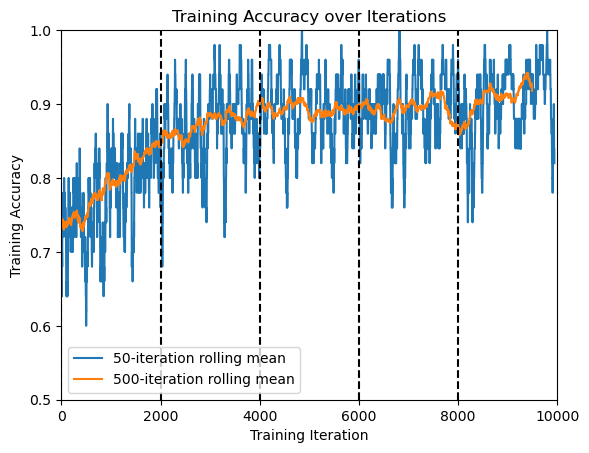

In [ ]:
#Plot training accuracy rolling mean

import matplotlib.pyplot as plt
plt.plot([np.array(all_iter_accuracies)[i:i+50].mean() for i in range(len(all_iter_accuracies) - 50)], label = '50-iteration rolling mean')
plt.plot([np.array(all_iter_accuracies)[i:i+500].mean() for i in range(len(all_iter_accuracies) - 500)], label = '500-iteration rolling mean')
for xval in range(0, 1998*5, 1998):
    plt.plot([xval, xval], [0.5, 1], '--k')

plt.ylim([0.5, 1])
plt.xlim([0, 10000])
plt.xlabel('Training Iteration')
plt.ylabel('Training Accuracy')
plt.legend()
plt.title("Training Accuracy over Iterations")

Text(0.5, 1.0, 'Training Loss over Iterations')

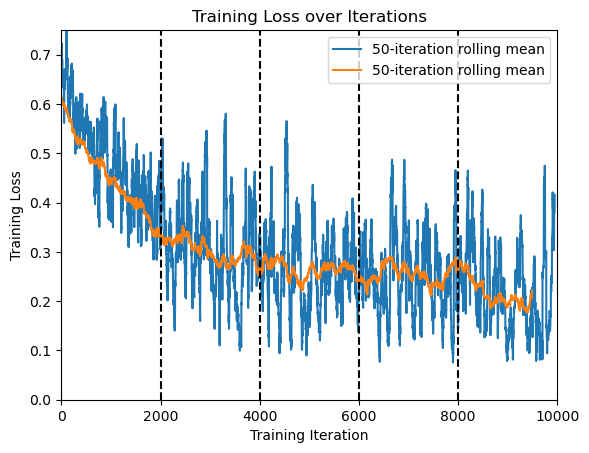

In [ ]:
#Plot training loss rolling mean

plt.plot([np.array(all_iter_losses)[i:i+50].mean() for i in range(len(all_iter_losses) - 50)], label = '50-iteration rolling mean')
plt.plot([np.array(all_iter_losses)[i:i+500].mean() for i in range(len(all_iter_losses) - 500)], label = '50-iteration rolling mean')

for xval in range(0, 1998*5, 1998):
    plt.plot([xval, xval], [0, 0.75], '--k')

plt.ylim([0, 0.75])
plt.xlim([0, 10000])
plt.xlabel('Training Iteration')
plt.ylabel('Training Loss')
plt.legend()
plt.title("Training Loss over Iterations")

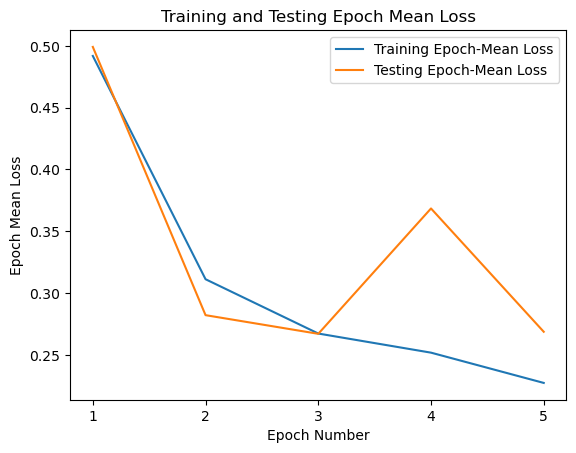

In [ ]:
#Plot training and testing epoch losses

plt.plot(np.array(all_epoch_losses) / 1998, label = 'Training Epoch-Mean Loss')
plt.plot(np.array(all_epoch_losses_test) / 440, label = 'Testing Epoch-Mean Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Epoch Mean Loss')
plt.legend()
plt.title('Training and Testing Epoch Mean Loss')
xt = plt.xticks(np.arange(0, 5), np.arange(1, 6))




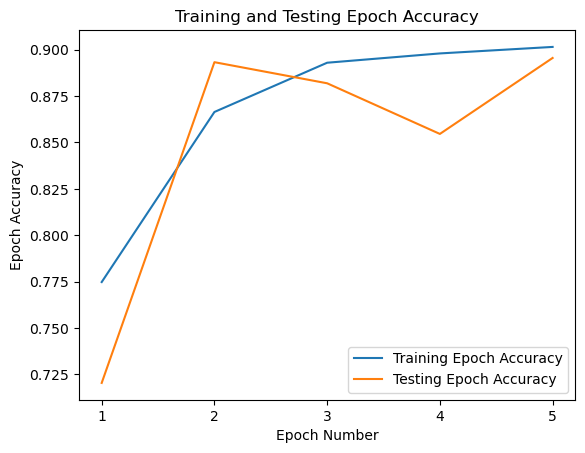

In [ ]:
#Plot training and testing epoch accuracies

plt.plot(all_epoch_accuracies, label = 'Training Epoch Accuracy')
plt.plot(all_epoch_accuracies_test, label = 'Testing Epoch Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Epoch Accuracy')
plt.legend()
plt.title('Training and Testing Epoch Accuracy')
xt = plt.xticks(np.arange(0, 5), np.arange(1, 6))

In [ ]:
#Evaluate the model with the testing data in each group

model.eval()
severe_preds = [model(testdatalist[i]).item() for i in range(110)]
null_preds = [model(testdatalist[i]).item() for i in range(110, 220)]
tstm_preds = [model(testdatalist[i]).item() for i in range(220, 330)]
stratiform_preds = [model(testdatalist[i]).item() for i in range(330, 440)]





In [ ]:
#Print number of "1" (warning) predictions per group

print((np.array(stratiform_preds) > 0.5).sum())
print((np.array(null_preds) > 0.5).sum())
print((np.array(tstm_preds) > 0.5).sum())
print((np.array(severe_preds) > 0.5).sum())

0
0
19
83


In [ ]:
#Print number of correct and incorrect predictions in each group

sev_correct_idxs = np.argwhere(np.array(severe_preds) > 0.5).squeeze()
sev_incorrect_idxs = np.argwhere(np.array(severe_preds) < 0.5).squeeze()
print(len(sev_correct_idxs))
print(len(sev_incorrect_idxs))

ts_correct_idxs = np.argwhere(np.array(tstm_preds) < 0.5).squeeze()
ts_incorrect_idxs = np.argwhere(np.array(tstm_preds) > 0.5).squeeze()
print(len(ts_correct_idxs))
print(len(ts_incorrect_idxs))

nu_correct_idxs = np.argwhere(np.array(null_preds) < 0.5).squeeze()
nu_incorrect_idxs = np.argwhere(np.array(null_preds) > 0.5).squeeze()
print(len(nu_correct_idxs))
print(len(nu_incorrect_idxs))

sf_correct_idxs = np.argwhere(np.array(stratiform_preds) < 0.5).squeeze()
sf_incorrect_idxs = np.argwhere(np.array(stratiform_preds) > 0.5).squeeze()
print(len(sf_correct_idxs))
print(len(sf_incorrect_idxs))


83
27
91
19
110
0
110
0


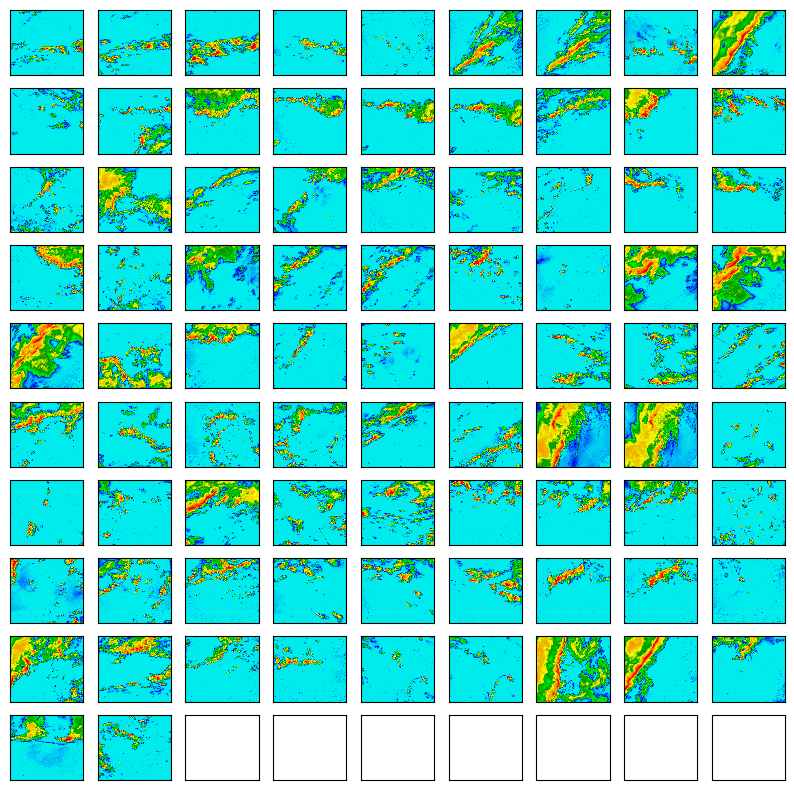

In [ ]:
#Plot reflectivity slices from correctly predicted severe events

import matplotlib.pyplot as plt, xradar as xd, pyart, nexradaws, wget
fig, ax = plt.subplots(10, 9, figsize = [10, 10])
ax = ax.flatten()
for axidx, fileidx in enumerate(sev_correct_idxs):
    pcm = ax[axidx].pcolormesh(xr.open_dataset(r"C:\Users\benja\Downloads\radar_file_" + str(500 + fileidx) + ".nc").squeeze().reflectivity.fillna(0).to_numpy()[0:10, :, :][1], cmap='NWSRef', vmin = 5, vmax = 75)
    ax[axidx].set_xticks([])
    ax[axidx].set_yticks([])

for axidx in range(83, 90):
    ax[axidx].set_xticks([])
    ax[axidx].set_yticks([])


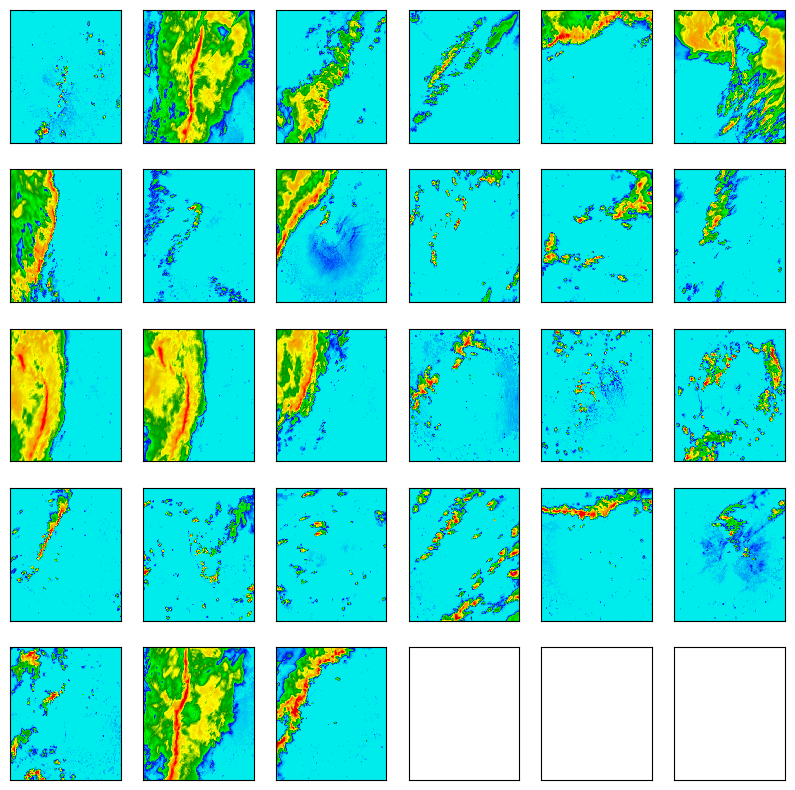

In [ ]:
#Plot reflectivity slices from incorrectly predicted true severe events


import matplotlib.pyplot as plt, xradar as xd, pyart, nexradaws, wget
fig, ax = plt.subplots(5, 6, figsize = [10, 10])
ax = ax.flatten()
for axidx, fileidx in enumerate(sev_incorrect_idxs):
    pcm = ax[axidx].pcolormesh(xr.open_dataset(r"C:\Users\benja\Downloads\radar_file_" + str(500 + fileidx) + ".nc").squeeze().reflectivity.fillna(0).to_numpy()[0:10, :, :][1], cmap='NWSRef', vmin = 5, vmax = 75)
    ax[axidx].set_xticks([])
    ax[axidx].set_yticks([])

for axidx in range(27, 30):
    ax[axidx].set_xticks([])
    ax[axidx].set_yticks([])


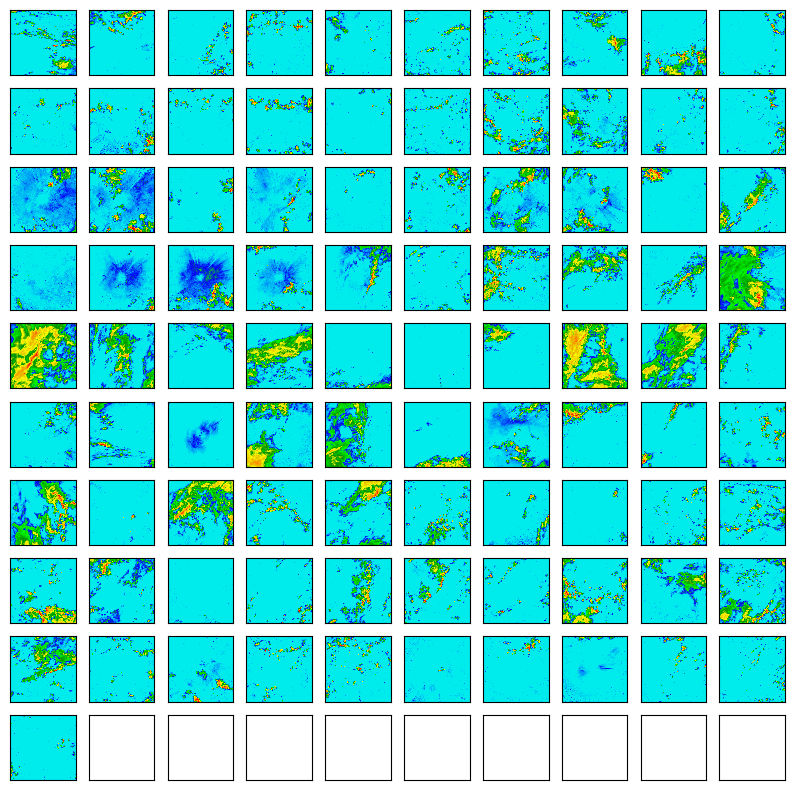

In [ ]:
#Plot reflectivity slices from correctly predicted true thunderstorm non-events


import matplotlib.pyplot as plt, xradar as xd, pyart, nexradaws, wget
fig, ax = plt.subplots(10, 10, figsize = [10, 10])
ax = ax.flatten()
for axidx, fileidx in enumerate(ts_correct_idxs):
    pcm = ax[axidx].pcolormesh(xr.open_dataset(r"C:\Users\benja\Downloads\tstm_nonevent_radar_file_" + str(500 + fileidx) + ".nc").squeeze().reflectivity.fillna(0).to_numpy()[0:10, :, :][1], cmap='NWSRef', vmin = 5, vmax = 75)
    ax[axidx].set_xticks([])
    ax[axidx].set_yticks([])

for axidx in range(91, 100):
    ax[axidx].set_xticks([])
    ax[axidx].set_yticks([])


#plt.tight_layout()
#plt.colorbar(pcm)

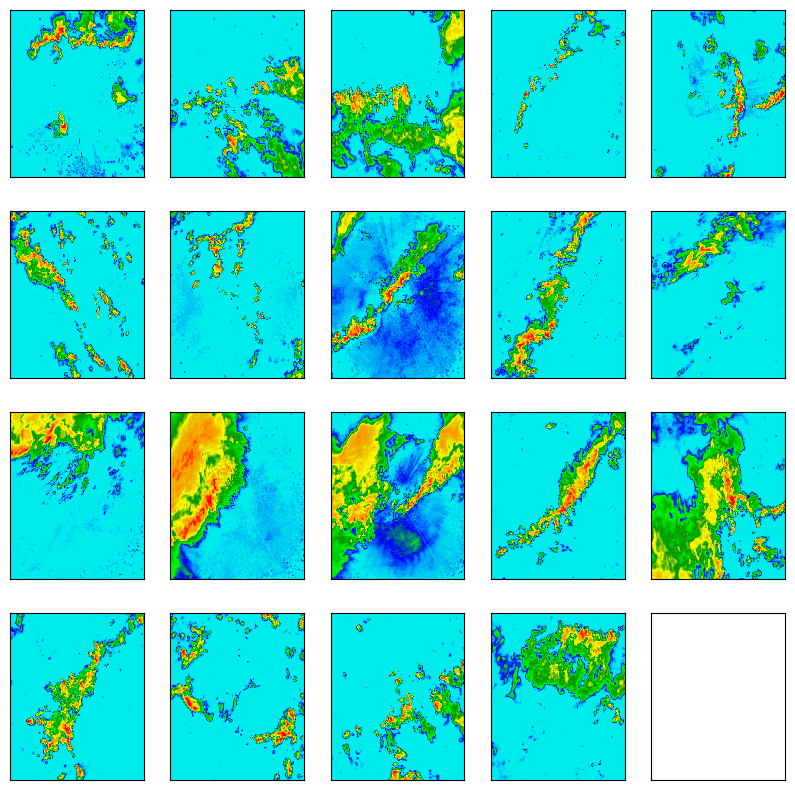

In [ ]:
#Plot reflectivity slices from incorrectly predicted true thunderstorm non-events


import matplotlib.pyplot as plt, xradar as xd, pyart, nexradaws, wget
fig, ax = plt.subplots(4, 5, figsize = [10, 10])
ax = ax.flatten()
for axidx, fileidx in enumerate(ts_incorrect_idxs):
    pcm = ax[axidx].pcolormesh(xr.open_dataset(r"C:\Users\benja\Downloads\tstm_nonevent_radar_file_" + str(500 + fileidx) + ".nc").squeeze().reflectivity.fillna(0).to_numpy()[0:10, :, :][1], cmap='NWSRef', vmin = 5, vmax = 75)
    ax[axidx].set_xticks([])
    ax[axidx].set_yticks([])

for axidx in range(19, 20):
    ax[axidx].set_xticks([])
    ax[axidx].set_yticks([])


#plt.tight_layout()
#plt.colorbar(pcm)